In [1]:
%run import_libs.py

### get data

In [2]:
df_train = get_train_data(TRAIN_PATH='./data/train.parquet')
num_features = pd.read_csv("num_feats_after_filtering.csv")["0"].to_list()

df_train_agg = get_df_w_aggrs(df=df_train, feats=num_features)
df_train_target = get_target(TARGET_PATH='./data/train_labels.csv')
df_train = get_train_data_with_target_merged(df_train=df_train_agg, df_train_target=df_train_target)

(458913, 151)
(458913, 151)
(458913, 151)
(458913, 162)
(458913, 616)


In [3]:
df_test = get_test_data(TEST_PATH='./data/test.parquet')
df_test = get_df_w_aggrs(df=df_test, feats=num_features)

(924621, 151)
(924621, 151)
(924621, 151)
(924621, 162)
(924621, 616)


In [4]:
df_train.head(3)

,customer_ID,P_2_min,P_3_min,P_4_min,D_39_min,D_41_min,D_42_min,D_43_min,D_44_min,D_45_min,...,D_114_last,D_116_last,D_117_last,D_120_last,D_126_last,D_63_last,D_64_last,D_66_last,D_68_last,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.868580,0.581678,0.0,0,0.0,NaN,NaN,0,0.708906,...,1,0,5,0,2,0,0,-1,6,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0.861109,0.510142,0.0,0,0.0,NaN,0.060646,0,0.239459,...,1,0,0,0,2,3,0,-1,6,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0.797670,0.381123,0.0,0,0.0,NaN,NaN,0,0.222406,...,1,0,0,0,2,3,2,-1,6,0


In [5]:
df_test.head(3)

,customer_ID,P_2_min,P_3_min,P_4_min,D_39_min,D_41_min,D_42_min,D_43_min,D_44_min,D_45_min,...,B_38_last,D_114_last,D_116_last,D_117_last,D_120_last,D_126_last,D_63_last,D_64_last,D_66_last,D_68_last
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.568930,0.535311,0.958618,0,0.0,0.103745,0.006272,0,0.004483,...,2,0,0,0,1,1,0,3,-1,6
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.794469,0.385655,0.000000,0,0.0,NaN,NaN,0,0.076225,...,2,1,0,4,0,2,3,0,-1,6
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.673112,0.381666,0.000000,0,0.0,NaN,0.085228,0,0.041670,...,2,0,0,4,0,1,0,3,1,4


In [6]:
cat_features = [f"{f}_last" for f in ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']]
cat_features

['B_30_last',
 'B_38_last',
 'D_114_last',
 'D_116_last',
 'D_117_last',
 'D_120_last',
 'D_126_last',
 'D_63_last',
 'D_64_last',
 'D_66_last',
 'D_68_last']

In [7]:
payment_feats = []
delinq_feats = []
spend_feats = []
balance_feats = []
risk_feats = []

for feat in list(df_train):
    if feat in cat_features:
        continue
    
    if feat[0] == 'P':
        #print(feat)
        payment_feats.append(feat)
    elif feat[0] == 'D':
        delinq_feats.append(feat)
    elif feat[0] == 'S':
        spend_feats.append(feat)
    elif feat[0] == 'B':
        balance_feats.append(feat)
    elif feat[0] == 'R':
        risk_feats.append(feat)

In [8]:
len(payment_feats) + len(delinq_feats) + len(spend_feats) + len(balance_feats) + len(risk_feats)

604

In [9]:
num_features = payment_feats + delinq_feats + spend_feats + balance_feats + risk_feats
len(num_features)

604

### LightGBM (all features)

In [ ]:
feature_cols = num_features + cat_features
X = df_train[feature_cols]
y = df_train['target'].values
groups = df_train['customer_ID'].values

params = dict(
    learning_rate   = 0.05,
    subsample       = 0.9,
    subsample_freq  = 1,          # без этой штуки subsample у lgbm не заработает
    colsample_bytree= 0.8,
    num_leaves      = 64,
    max_depth       = 5,
    n_estimators    = 350,
    objective       = 'binary',
    verbosity       = -1,
    random_state    = 42
)

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
fold_scores = [] # train_cv scores
y_pred_list = [] # test scores to submit

for fold, (tr_idx, va_idx) in enumerate(sgkf.split(
        X=df_train[['customer_ID', 'target']],
        y=y,
        groups=groups)):
    
    print(f"Fold {fold}")
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y[tr_idx], y[va_idx]
    
    model = LGBMClassifier(**params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric=lgb_amex_metric,
        categorical_feature=cat_features
    )
    
    y_pred = model.predict_proba(X_va)[:, 1]
    score = get_amex_metric_calculated(y_va, y_pred)
    print(f"  Amex = {score:.5f}")
    fold_scores.append(score)

    # predict test at each fold
    y_pred_list.append(model.predict_proba(df_test[feature_cols], raw_score=True))

print(f"\nMean CV Amex: {np.mean(fold_scores):.5f} ± {np.std(fold_scores):.5f}")

Fold 0
  Amex = 0.78540
Fold 1
  Amex = 0.78871
Fold 2
  Amex = 0.78870
Fold 3
  Amex = 0.78663
Fold 4
  Amex = 0.78985

Mean CV Amex: 0.78786 ± 0.00161


In [31]:
INFERENCE = True

if INFERENCE:
    sub = pd.DataFrame({'customer_ID': df_test.customer_ID,
                        'prediction': np.mean(y_pred_list, axis=0)})
    sub.to_csv('submission_lgbm_all_features.csv', index=False)
    display(sub)

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,-3.112161
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,-6.483655
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,-2.919210
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,-0.519460
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,1.987848
...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,-3.867522
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,1.531089
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,0.238545
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,-0.620260


### Random Forest (all features)

### TabNet (all features)

### Backward selection (lgbm)

In [10]:
log_df, list_imp_dfs, remaining, test_preds = run_backward_selection(
    df_train=df_train,
    df_test=df_test,
    target_col='target',
    num_feats=num_features,
    cat_feats=cat_features,
    group_col='customer_ID',
    min_feats=10
)


=== Step 0 | feats 615 (num 604, cat 11) | depth 6 trees 400
Fold 0
 Amex = 0.78621
Fold 1
 Amex = 0.79092
Fold 2
 Amex = 0.78966
Fold 3
 Amex = 0.78750
Fold 4
 Amex = 0.78977
Mean CV Amex = 0.78881  CI95 = [0.78644, 0.79118]

=== Step 1 | feats 554 (num 545, cat 9) | depth 6 trees 400
Fold 0
 Amex = 0.78640
Fold 1
 Amex = 0.79214
Fold 2
 Amex = 0.79063
Fold 3
 Amex = 0.78861
Fold 4
 Amex = 0.78964
Mean CV Amex = 0.78948  CI95 = [0.78680, 0.79217]


[I 2025-05-07 01:01:15,170] A new study created in memory with name: no-name-5c49cd09-571d-4aa7-b474-2a3545d20051


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-07 01:22:17,839] Trial 3 finished with value: -0.7746367308230045 and parameters: {'max_depth': 2, 'n_estimators': 359}. Best is trial 3 with value: -0.7746367308230045.
[I 2025-05-07 01:23:36,618] Trial 7 finished with value: -0.7845922081827592 and parameters: {'max_depth': 3, 'n_estimators': 469}. Best is trial 7 with value: -0.7845922081827592.
[I 2025-05-07 01:27:21,111] Trial 9 finished with value: -0.7832933219860643 and parameters: {'max_depth': 3, 'n_estimators': 405}. Best is trial 7 with value: -0.7845922081827592.
[I 2025-05-07 01:29:45,032] Trial 1 finished with value: -0.7871525306122276 and parameters: {'max_depth': 4, 'n_estimators': 432}. Best is trial 1 with value: -0.7871525306122276.
[I 2025-05-07 01:30:50,151] Trial 0 finished with value: -0.7852528004648184 and parameters: {'max_depth': 4, 'n_estimators': 321}. Best is trial 1 with value: -0.7871525306122276.
[I 2025-05-07 01:32:50,533] Trial 11 finished with value: -0.7842214524071225 and parameters: {

[I 2025-05-07 02:13:18,597] A new study created in memory with name: no-name-00044dc0-80f6-4717-9b59-66cf7b2a0910


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-07 02:31:02,211] Trial 8 finished with value: -0.7691290095620011 and parameters: {'max_depth': 2, 'n_estimators': 256}. Best is trial 8 with value: -0.7691290095620011.
[I 2025-05-07 02:31:25,470] Trial 11 finished with value: -0.7708403609262844 and parameters: {'max_depth': 2, 'n_estimators': 284}. Best is trial 11 with value: -0.7708403609262844.
[I 2025-05-07 02:33:05,206] Trial 6 finished with value: -0.778075700184494 and parameters: {'max_depth': 2, 'n_estimators': 444}. Best is trial 6 with value: -0.778075700184494.
[I 2025-05-07 02:35:43,972] Trial 7 finished with value: -0.7882971661769034 and parameters: {'max_depth': 5, 'n_estimators': 351}. Best is trial 7 with value: -0.7882971661769034.
[I 2025-05-07 02:36:26,941] Trial 4 finished with value: -0.7822299978657338 and parameters: {'max_depth': 3, 'n_estimators': 378}. Best is trial 7 with value: -0.7882971661769034.
[I 2025-05-07 02:36:34,292] Trial 9 finished with value: -0.7836884111754082 and parameters: {'

[I 2025-05-07 03:08:00,901] A new study created in memory with name: no-name-d372f0c9-0006-4f77-b483-79ef0b250ff9


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-07 03:22:51,536] Trial 7 finished with value: -0.7784279272425347 and parameters: {'max_depth': 2, 'n_estimators': 477}. Best is trial 7 with value: -0.7784279272425347.
[I 2025-05-07 03:25:25,035] Trial 8 finished with value: -0.7777164700874037 and parameters: {'max_depth': 3, 'n_estimators': 256}. Best is trial 7 with value: -0.7784279272425347.
[I 2025-05-07 03:27:46,159] Trial 1 finished with value: -0.7880887612877192 and parameters: {'max_depth': 8, 'n_estimators': 278}. Best is trial 1 with value: -0.7880887612877192.
[I 2025-05-07 03:32:45,795] Trial 12 finished with value: -0.7840229985385401 and parameters: {'max_depth': 3, 'n_estimators': 454}. Best is trial 1 with value: -0.7880887612877192.
[I 2025-05-07 03:33:14,903] Trial 9 finished with value: -0.7861418272137496 and parameters: {'max_depth': 6, 'n_estimators': 243}. Best is trial 1 with value: -0.7880887612877192.
[I 2025-05-07 03:33:16,175] Trial 0 finished with value: -0.7870889862047965 and parameters: {

[I 2025-05-07 03:54:46,458] A new study created in memory with name: no-name-6f10310b-6606-4709-9566-ea83b78c9843


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-07 04:10:11,483] Trial 1 finished with value: -0.7841747580209468 and parameters: {'max_depth': 4, 'n_estimators': 292}. Best is trial 1 with value: -0.7841747580209468.
[I 2025-05-07 04:11:48,078] Trial 7 finished with value: -0.7873335004414415 and parameters: {'max_depth': 8, 'n_estimators': 291}. Best is trial 7 with value: -0.7873335004414415.
[I 2025-05-07 04:12:24,789] Trial 0 finished with value: -0.7823159471305786 and parameters: {'max_depth': 3, 'n_estimators': 390}. Best is trial 7 with value: -0.7873335004414415.
[I 2025-05-07 04:14:10,278] Trial 3 finished with value: -0.7851531987256832 and parameters: {'max_depth': 4, 'n_estimators': 326}. Best is trial 7 with value: -0.7873335004414415.
[I 2025-05-07 04:14:42,627] Trial 10 finished with value: -0.7839402535786013 and parameters: {'max_depth': 5, 'n_estimators': 228}. Best is trial 7 with value: -0.7873335004414415.
[I 2025-05-07 04:16:03,741] Trial 8 finished with value: -0.7871041661742856 and parameters: {

[I 2025-05-07 04:36:56,150] A new study created in memory with name: no-name-3d2c78d4-8308-43fc-a873-06c2124efcbe


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-07 04:50:52,899] Trial 7 finished with value: -0.775810390264571 and parameters: {'max_depth': 2, 'n_estimators': 396}. Best is trial 7 with value: -0.775810390264571.
[I 2025-05-07 04:52:35,587] Trial 5 finished with value: -0.7753251784285716 and parameters: {'max_depth': 3, 'n_estimators': 220}. Best is trial 7 with value: -0.775810390264571.
[I 2025-05-07 04:53:31,665] Trial 4 finished with value: -0.7792766552352642 and parameters: {'max_depth': 3, 'n_estimators': 305}. Best is trial 4 with value: -0.7792766552352642.
[I 2025-05-07 04:53:50,548] Trial 11 finished with value: -0.780646334872506 and parameters: {'max_depth': 4, 'n_estimators': 230}. Best is trial 11 with value: -0.780646334872506.
[I 2025-05-07 04:54:49,801] Trial 1 finished with value: -0.7877338159058995 and parameters: {'max_depth': 8, 'n_estimators': 317}. Best is trial 1 with value: -0.7877338159058995.
[I 2025-05-07 04:55:11,898] Trial 0 finished with value: -0.7857408688576595 and parameters: {'max

[I 2025-05-07 05:13:43,096] A new study created in memory with name: no-name-6eb0c05b-d212-408a-b335-95d199a41dce


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-07 05:27:14,653] Trial 1 finished with value: -0.7799957862273084 and parameters: {'max_depth': 4, 'n_estimators': 218}. Best is trial 1 with value: -0.7799957862273084.
[I 2025-05-07 05:28:07,228] Trial 0 finished with value: -0.7656890983957221 and parameters: {'max_depth': 2, 'n_estimators': 217}. Best is trial 1 with value: -0.7799957862273084.
[I 2025-05-07 05:29:44,669] Trial 7 finished with value: -0.7872136157054855 and parameters: {'max_depth': 6, 'n_estimators': 402}. Best is trial 7 with value: -0.7872136157054855.
[I 2025-05-07 05:29:49,669] Trial 4 finished with value: -0.7759146499327335 and parameters: {'max_depth': 2, 'n_estimators': 407}. Best is trial 7 with value: -0.7872136157054855.
[I 2025-05-07 05:30:05,141] Trial 3 finished with value: -0.7796625373800626 and parameters: {'max_depth': 3, 'n_estimators': 324}. Best is trial 7 with value: -0.7872136157054855.
[I 2025-05-07 05:31:07,781] Trial 10 finished with value: -0.7820671811808123 and parameters: {

[I 2025-05-07 05:46:32,069] A new study created in memory with name: no-name-3c0f88e8-59da-4c99-bb0b-51a890c6e53c


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-07 06:01:37,072] Trial 9 finished with value: -0.776749010665483 and parameters: {'max_depth': 2, 'n_estimators': 475}. Best is trial 9 with value: -0.776749010665483.
[I 2025-05-07 06:02:04,750] Trial 5 finished with value: -0.7796042361753912 and parameters: {'max_depth': 4, 'n_estimators': 222}. Best is trial 5 with value: -0.7796042361753912.
[I 2025-05-07 06:03:59,778] Trial 11 finished with value: -0.7826639428182893 and parameters: {'max_depth': 5, 'n_estimators': 246}. Best is trial 11 with value: -0.7826639428182893.
[I 2025-05-07 06:04:03,451] Trial 7 finished with value: -0.7864094026300464 and parameters: {'max_depth': 7, 'n_estimators': 495}. Best is trial 7 with value: -0.7864094026300464.
[I 2025-05-07 06:04:23,498] Trial 1 finished with value: -0.7859548749240947 and parameters: {'max_depth': 8, 'n_estimators': 354}. Best is trial 7 with value: -0.7864094026300464.
[I 2025-05-07 06:04:24,201] Trial 4 finished with value: -0.7832707704491083 and parameters: {'

[I 2025-05-07 06:20:37,719] A new study created in memory with name: no-name-4dda8fa6-931c-412c-a4be-ffa1d84110a7


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-07 06:34:00,894] Trial 7 finished with value: -0.7809891420533827 and parameters: {'max_depth': 5, 'n_estimators': 294}. Best is trial 7 with value: -0.7809891420533827.
[I 2025-05-07 06:34:57,038] Trial 11 finished with value: -0.7713999655098346 and parameters: {'max_depth': 2, 'n_estimators': 329}. Best is trial 7 with value: -0.7809891420533827.
[I 2025-05-07 06:34:59,292] Trial 9 finished with value: -0.7684968444598994 and parameters: {'max_depth': 2, 'n_estimators': 268}. Best is trial 7 with value: -0.7809891420533827.
[I 2025-05-07 06:35:14,964] Trial 2 finished with value: -0.7718823628093321 and parameters: {'max_depth': 3, 'n_estimators': 200}. Best is trial 7 with value: -0.7809891420533827.
[I 2025-05-07 06:35:17,345] Trial 3 finished with value: -0.7739428776200193 and parameters: {'max_depth': 3, 'n_estimators': 236}. Best is trial 7 with value: -0.7809891420533827.
[I 2025-05-07 06:35:24,383] Trial 1 finished with value: -0.7820978550012463 and parameters: {

[I 2025-05-07 06:51:13,530] A new study created in memory with name: no-name-1e0f0e4a-16ff-4fa8-828b-82617ad72d8d


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-07 07:04:38,915] Trial 7 finished with value: -0.7684622495455049 and parameters: {'max_depth': 2, 'n_estimators': 299}. Best is trial 7 with value: -0.7684622495455049.
[I 2025-05-07 07:05:30,453] Trial 10 finished with value: -0.7714757251336424 and parameters: {'max_depth': 2, 'n_estimators': 380}. Best is trial 10 with value: -0.7714757251336424.
[I 2025-05-07 07:06:10,305] Trial 4 finished with value: -0.7735933179650564 and parameters: {'max_depth': 2, 'n_estimators': 470}. Best is trial 4 with value: -0.7735933179650564.
[I 2025-05-07 07:06:59,748] Trial 1 finished with value: -0.7788521071627303 and parameters: {'max_depth': 5, 'n_estimators': 284}. Best is trial 1 with value: -0.7788521071627303.
[I 2025-05-07 07:07:12,712] Trial 8 finished with value: -0.7788020723544212 and parameters: {'max_depth': 5, 'n_estimators': 283}. Best is trial 1 with value: -0.7788521071627303.
[I 2025-05-07 07:07:13,568] Trial 5 finished with value: -0.7774360180697246 and parameters: 

[I 2025-05-07 07:22:46,521] A new study created in memory with name: no-name-4e286071-50a0-499f-96b3-cca7f10bc319


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-07 07:36:35,180] Trial 6 finished with value: -0.7662278598142664 and parameters: {'max_depth': 2, 'n_estimators': 288}. Best is trial 6 with value: -0.7662278598142664.
[I 2025-05-07 07:37:57,690] Trial 0 finished with value: -0.7769075242710949 and parameters: {'max_depth': 5, 'n_estimators': 384}. Best is trial 0 with value: -0.7769075242710949.
[I 2025-05-07 07:38:00,569] Trial 5 finished with value: -0.7771349477244704 and parameters: {'max_depth': 7, 'n_estimators': 319}. Best is trial 5 with value: -0.7771349477244704.
[I 2025-05-07 07:38:35,325] Trial 9 finished with value: -0.7741745839447531 and parameters: {'max_depth': 3, 'n_estimators': 407}. Best is trial 5 with value: -0.7771349477244704.
[I 2025-05-07 07:38:50,093] Trial 10 finished with value: -0.7768423023061626 and parameters: {'max_depth': 7, 'n_estimators': 305}. Best is trial 5 with value: -0.7771349477244704.
[I 2025-05-07 07:38:55,972] Trial 4 finished with value: -0.7768955331345259 and parameters: {

[I 2025-05-07 07:53:19,690] A new study created in memory with name: no-name-55dbb605-65c0-4433-beb6-089dde18edb5


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-07 08:07:06,767] Trial 6 finished with value: -0.7707593802333829 and parameters: {'max_depth': 7, 'n_estimators': 248}. Best is trial 6 with value: -0.7707593802333829.
[I 2025-05-07 08:07:49,493] Trial 11 finished with value: -0.7707693611825956 and parameters: {'max_depth': 7, 'n_estimators': 247}. Best is trial 11 with value: -0.7707693611825956.
[I 2025-05-07 08:08:23,965] Trial 5 finished with value: -0.7614882596115786 and parameters: {'max_depth': 2, 'n_estimators': 270}. Best is trial 11 with value: -0.7707693611825956.
[I 2025-05-07 08:08:44,740] Trial 0 finished with value: -0.7707954908203449 and parameters: {'max_depth': 6, 'n_estimators': 406}. Best is trial 0 with value: -0.7707954908203449.
[I 2025-05-07 08:12:02,985] Trial 4 finished with value: -0.7675375272888003 and parameters: {'max_depth': 4, 'n_estimators': 226}. Best is trial 0 with value: -0.7707954908203449.
[I 2025-05-07 08:12:15,364] Trial 9 finished with value: -0.765133427511798 and parameters: 

[I 2025-05-07 08:23:48,608] A new study created in memory with name: no-name-82e3e49d-aa91-4ceb-ae99-a6d700097808


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-07 08:44:32,175] Trial 5 finished with value: -0.7519327387078742 and parameters: {'max_depth': 2, 'n_estimators': 216}. Best is trial 5 with value: -0.7519327387078742.
[I 2025-05-07 08:44:55,473] Trial 6 finished with value: -0.759813595053912 and parameters: {'max_depth': 4, 'n_estimators': 249}. Best is trial 6 with value: -0.759813595053912.
[I 2025-05-07 08:45:33,637] Trial 11 finished with value: -0.7620186051951388 and parameters: {'max_depth': 5, 'n_estimators': 261}. Best is trial 11 with value: -0.7620186051951388.
[I 2025-05-07 08:45:43,642] Trial 7 finished with value: -0.7607273172481217 and parameters: {'max_depth': 4, 'n_estimators': 291}. Best is trial 11 with value: -0.7620186051951388.
[I 2025-05-07 08:46:01,591] Trial 2 finished with value: -0.761197677738035 and parameters: {'max_depth': 8, 'n_estimators': 212}. Best is trial 11 with value: -0.7620186051951388.
[I 2025-05-07 08:46:01,712] Trial 0 finished with value: -0.7621129304598604 and parameters: {

[I 2025-05-07 08:58:37,951] A new study created in memory with name: no-name-3ecfb694-d0cc-402e-ae6f-6bf3ccb9d555


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-07 09:10:36,117] Trial 0 finished with value: -0.7510679261945511 and parameters: {'max_depth': 3, 'n_estimators': 224}. Best is trial 0 with value: -0.7510679261945511.
[I 2025-05-07 09:10:58,426] Trial 6 finished with value: -0.7487742834354546 and parameters: {'max_depth': 2, 'n_estimators': 274}. Best is trial 0 with value: -0.7510679261945511.
[I 2025-05-07 09:11:20,237] Trial 11 finished with value: -0.7523361759703928 and parameters: {'max_depth': 3, 'n_estimators': 289}. Best is trial 11 with value: -0.7523361759703928.
[I 2025-05-07 09:13:45,676] Trial 5 finished with value: -0.7559503582628571 and parameters: {'max_depth': 8, 'n_estimators': 418}. Best is trial 5 with value: -0.7559503582628571.
[I 2025-05-07 09:16:55,711] Trial 7 finished with value: -0.7555238271219917 and parameters: {'max_depth': 6, 'n_estimators': 214}. Best is trial 5 with value: -0.7559503582628571.
[I 2025-05-07 09:17:13,219] Trial 1 finished with value: -0.755589068395624 and parameters: {

[I 2025-05-07 09:28:27,120] A new study created in memory with name: no-name-e297b1d0-434b-4cd7-846e-9ced572639f1


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-07 09:41:01,450] Trial 8 finished with value: -0.7319316401745591 and parameters: {'max_depth': 6, 'n_estimators': 206}. Best is trial 8 with value: -0.7319316401745591.
[I 2025-05-07 09:41:12,157] Trial 7 finished with value: -0.7313877510656074 and parameters: {'max_depth': 4, 'n_estimators': 232}. Best is trial 8 with value: -0.7319316401745591.
[I 2025-05-07 09:42:29,122] Trial 1 finished with value: -0.7323930887218124 and parameters: {'max_depth': 8, 'n_estimators': 338}. Best is trial 1 with value: -0.7323930887218124.
[I 2025-05-07 09:43:45,898] Trial 2 finished with value: -0.7324442664989346 and parameters: {'max_depth': 5, 'n_estimators': 378}. Best is trial 2 with value: -0.7324442664989346.
[I 2025-05-07 09:45:13,683] Trial 5 finished with value: -0.7322193243490859 and parameters: {'max_depth': 8, 'n_estimators': 379}. Best is trial 2 with value: -0.7324442664989346.
[I 2025-05-07 09:45:15,025] Trial 6 finished with value: -0.7325480900954121 and parameters: {'

In [11]:
log_df

,step,n_feats_left,n_num_left,n_cat_left,max_depth,n_estimators,cv_mean,cv_ci_lo,cv_ci_hi
0,0,615,545,9,6,400,0.788812,0.786443,0.791182
1,1,554,492,7,6,400,0.789482,0.786798,0.792166
2,2,499,443,7,6,471,0.790431,0.788130,0.792732
3,3,450,398,7,6,471,0.789769,0.786424,0.793115
4,4,405,359,6,6,471,0.790460,0.788618,0.792302
...,...,...,...,...,...,...,...,...,...
66,66,15,14,0,4,496,0.734267,0.732557,0.735978
67,67,14,13,0,5,343,0.732548,0.729546,0.735550
68,68,13,12,0,5,343,0.722497,0.719298,0.725697
69,69,12,11,0,5,343,0.717309,0.714100,0.720517


In [ ]:
# log_df.to_csv("logging_backward_selection.csv", index=False)

In [12]:
test_preds

,iter_0,iter_1,iter_2,iter_3,iter_4,iter_5,iter_6,iter_7,iter_8,iter_9,...,iter_61,iter_62,iter_63,iter_64,iter_65,iter_66,iter_67,iter_68,iter_69,iter_70
customer_ID,,,,,,,,,,,,,,,,,,,,,
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,-3.078056,-2.999967,-2.853148,-2.969148,-3.035347,-3.095639,-3.062201,-2.942163,-2.970820,-3.030018,...,-2.032164,-1.897746,-1.599702,-1.547543,-1.443184,-2.084962,-2.025200,-2.234050,-2.695889,-2.607409
00001bf2e77ff879fab36aa4fac689b9ba411dae63ae397d4263dafa1daedef5,-6.702183,-6.737930,-6.810135,-6.746857,-6.754359,-6.757628,-6.960932,-6.867967,-6.842074,-6.817643,...,-6.956875,-6.952221,-6.759035,-6.802649,-6.752630,-6.866384,-6.761018,-6.205827,-5.979155,-5.993605
0000210045da4f81e5f122c6bde5c2a617d03eef67f82c5e400fc98e7bd43ce8,-2.855031,-2.786837,-2.683124,-2.826380,-2.675865,-2.863548,-2.779232,-2.911566,-2.875213,-2.859951,...,-2.965814,-2.974418,-2.944545,-2.939891,-3.245841,-3.240978,-3.319478,-3.297610,-3.736398,-3.680498
00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976cf6e56734528702d694,-0.707975,-0.680779,-0.722414,-0.786188,-0.681048,-0.775927,-0.699795,-0.825846,-0.736408,-0.657252,...,-0.550724,-0.395605,-0.661418,-0.640397,-0.443943,-0.412028,-0.284130,-0.676092,-0.646251,-0.662671
00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9a4693dd914fca22557,2.023322,2.091120,2.112760,2.083592,2.151290,2.039662,2.039515,2.042663,2.032910,1.938860,...,1.307099,1.717748,1.886808,2.083211,2.472341,2.464469,2.350869,2.609579,2.331064,1.623781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c5d60460dba6dedc41e,-3.907352,-3.983526,-4.001435,-3.907380,-4.034820,-3.860154,-3.961086,-3.870036,-3.977637,-3.853864,...,-3.794809,-3.634545,-3.425386,-3.359565,-2.843199,-2.675414,-2.557906,-1.934102,-2.692841,-2.628736
ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3a4f0ca3de613b0b2ad,1.426784,1.458463,1.526469,1.412952,1.528592,1.421613,1.531313,1.553419,1.525148,1.593890,...,1.558869,1.668959,0.843336,0.863035,0.894369,0.525163,0.642280,0.078350,-0.095164,0.018360
ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475cb095d2443a68030f1,0.144397,0.104515,0.088813,0.019978,0.095631,0.088780,0.055024,0.064423,0.022844,-0.112833,...,0.880319,0.847744,0.669327,0.774416,0.693220,0.277878,0.339233,0.228370,-0.047803,-0.042132


In [ ]:
# test_preds.to_csv("test_preds.csv", index=False)

In [30]:
n_feats

11

In [31]:
INFERENCE = True

if INFERENCE:
    sub = pd.DataFrame({'customer_ID': test_preds.index,
                        'prediction': test_preds[f'iter_{step}'].values})
    sub.to_csv(f'submission_lgbm_test_backward_{n_feats}_feats.csv', index=False)
    display(sub)

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,-2.607409
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,-5.993605
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,-3.680498
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,-0.662671
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,1.623781
...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,-2.628736
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,0.018360
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,-0.042132
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,-1.377083


In [24]:
for step, n_feats in enumerate(log_df.n_feats_left):
    print(step, n_feats)
    #test_preds[f'iter_{step}']

0 615
1 554
2 499
3 450
4 405
5 365
6 329
7 297
8 268
9 242
10 230
11 219
12 209
13 199
14 190
15 181
16 172
17 164
18 156
19 149
20 142
21 135
22 129
23 123
24 117
25 112
26 107
27 102
28 97
29 93
30 89
31 85
32 81
33 77
34 74
35 71
36 68
37 65
38 62
39 59
40 57
41 55
42 53
43 51
44 49
45 47
46 45
47 43
48 41
49 39
50 37
51 35
52 33
53 31
54 29
55 27
56 25
57 24
58 23
59 22
60 21
61 20
62 19
63 18
64 17
65 16
66 15
67 14
68 13
69 12
70 11


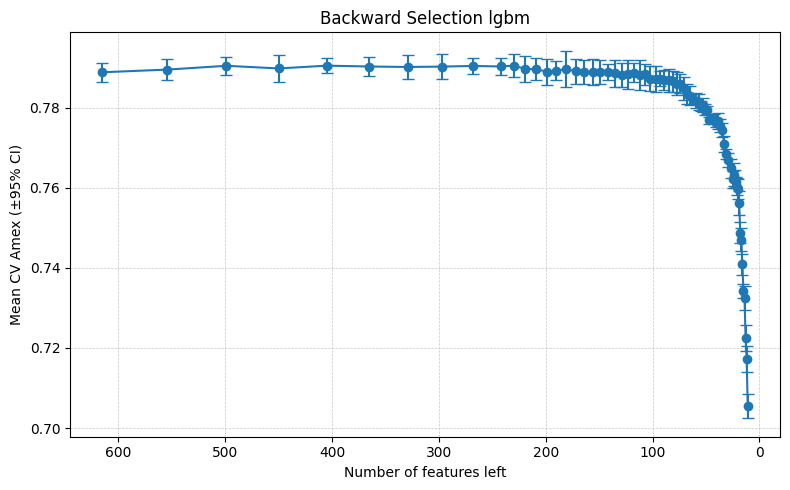

In [13]:
# Prepare data
plot_df = (log_df.sort_values('n_feats_left', ascending=False)
                   .reset_index(drop=True))

x = plot_df['n_feats_left']
y = plot_df['cv_mean']
yerr = [plot_df['cv_mean'] - plot_df['cv_ci_lo'],
        plot_df['cv_ci_hi'] - plot_df['cv_mean']]

# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=4)
plt.gca().invert_xaxis()                 # high → low features left
plt.xlabel("Number of features left")
plt.ylabel("Mean CV Amex (±95% CI)")
plt.title("Backward Selection lgbm")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# 35 featuures <- локоть
# 77.2 vs 79.0

In [ ]:
# save these things

# log_df, list_imp_dfs, remaining, test_preds

# log_df -> to_csv
# list_imp_dfs -> pickle 
# test_preds -> to csv, но вот это не знаю сколько весить будет, наверное много

In [34]:
test_preds

,iter_0,iter_1
customer_ID,,
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,-3.043706,-3.072459
00001bf2e77ff879fab36aa4fac689b9ba411dae63ae397d4263dafa1daedef5,-6.646934,-6.583331
0000210045da4f81e5f122c6bde5c2a617d03eef67f82c5e400fc98e7bd43ce8,-2.977684,-2.887134
00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976cf6e56734528702d694,-0.719216,-0.668750
00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9a4693dd914fca22557,2.160709,1.985517
...,...,...
ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c5d60460dba6dedc41e,-3.818989,-3.922272
ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3a4f0ca3de613b0b2ad,1.422425,1.505855
ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475cb095d2443a68030f1,0.021828,0.104337


In [37]:
INFERENCE = True

if INFERENCE:
    sub = pd.DataFrame({'customer_ID': test_preds.index,
                        'prediction': test_preds.iter_0.values})
    sub.to_csv('submission_lgbm_test_backward.csv', index=False)
    display(sub)

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,-3.043706
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,-6.646934
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,-2.977684
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,-0.719216
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,2.160709
...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,-3.818989
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,1.422425
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,0.021828
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,-0.475658


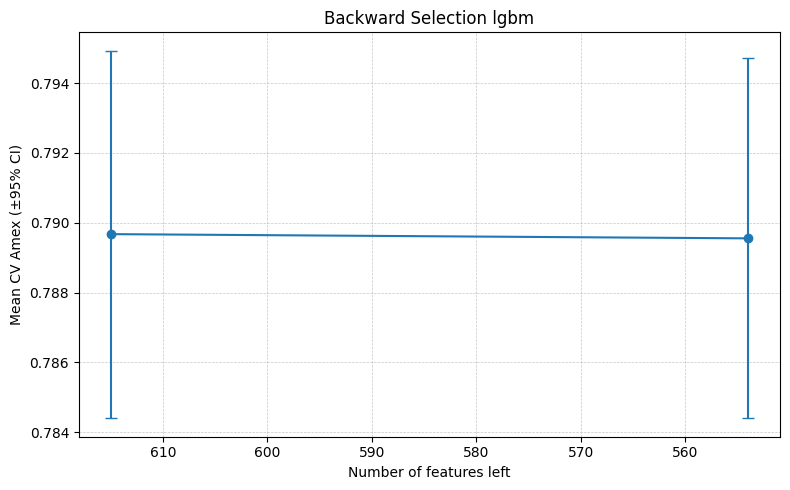

In [38]:
# Prepare data
plot_df = (log_df.sort_values('n_feats_left', ascending=False)
                   .reset_index(drop=True))

x = plot_df['n_feats_left']
y = plot_df['cv_mean']
yerr = [plot_df['cv_mean'] - plot_df['cv_ci_lo'],
        plot_df['cv_ci_hi'] - plot_df['cv_mean']]

# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=4)
plt.gca().invert_xaxis()                 # high → low features left
plt.xlabel("Number of features left")
plt.ylabel("Mean CV Amex (±95% CI)")
plt.title("Backward Selection lgbm")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

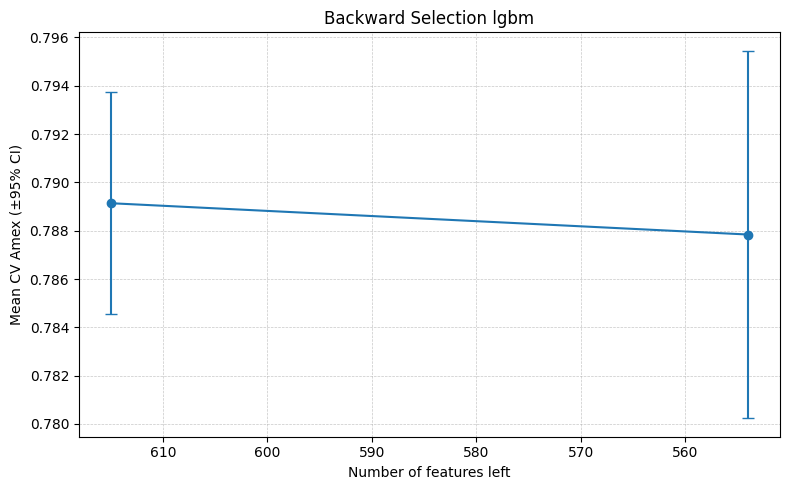

In [27]:
# Prepare data
plot_df = (log_df.sort_values('n_feats_left', ascending=False)
                   .reset_index(drop=True))

x = plot_df['n_feats_left']
y = plot_df['cv_mean']
yerr = [plot_df['cv_mean'] - plot_df['cv_ci_lo'],
        plot_df['cv_ci_hi'] - plot_df['cv_mean']]

# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=4)
plt.gca().invert_xaxis()                 # high → low features left
plt.xlabel("Number of features left")
plt.ylabel("Mean CV Amex (±95% CI)")
plt.title("Backward Selection lgbm")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [29]:
test_preds

,iter_0,iter_1
customer_ID,,
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,0.046447,0.047620
00001bf2e77ff879fab36aa4fac689b9ba411dae63ae397d4263dafa1daedef5,0.001367,0.001422
0000210045da4f81e5f122c6bde5c2a617d03eef67f82c5e400fc98e7bd43ce8,0.046379,0.047366
00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976cf6e56734528702d694,0.334431,0.360902
00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9a4693dd914fca22557,0.889791,0.885847
...,...,...
ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c5d60460dba6dedc41e,0.022109,0.021863
ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3a4f0ca3de613b0b2ad,0.816386,0.836843
ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475cb095d2443a68030f1,0.509889,0.494049


In [13]:
log_df, list_imp_dfs, remaining, test_preds = run_backward_selection(
    df_train=df_train,
    df_test=df_test,
    target_col='target',
    num_feats=num_features,
    cat_feats=cat_features,
    group_col='customer_ID',
    min_feats=500
)


=== Step 0 | feats 615 (num 604, cat 11) | depth 6 trees 350
Fold 0
 Amex = 0.78721
Fold 1
 Amex = 0.79089
Fold 2
 Amex = 0.78931
Mean CV Amex: 0.78914 ± 0.00151

=== Step 1 | feats 554 (num 545, cat 9) | depth 6 trees 350
Fold 0
 Amex = 0.78501
Fold 1
 Amex = 0.79109
Fold 2
 Amex = 0.78742
Mean CV Amex: 0.78784 ± 0.00250


In [ ]:
def run_backward_selection(df_train,
                           df_test,
                           target_col,
                           num_feats,
                           cat_feats,
                           group_col,
                           min_feats: int = 10,
                           random_state: int = 42):

    num, cat = num_feats.copy(), cat_feats.copy()
    history, list_imp_dfs,  step = [], [], 0
    sgkf = StratifiedGroupKFold(5, shuffle=True, random_state=random_state)
    test_preds_df = pd.DataFrame(index=df_test.customer_ID)  # accumulate test scores

    def n_to_drop(n):
        if n > 250: return max(1, int(n*.10))
        if n > 100: return max(1, int(n*.05))
        if n >  30: return max(1, int(n*.02))
        return 1

    def choose_params(n):
        if n > 250: return 6, 350
        if n > 100: return 5, 300
        if n >  50: return 3, 300
        if n >  10: return 2, 250
        return        2, 250

    y = df_train[target_col].values
    groups = df_train[group_col].values

    while True:
        feats = num + cat
        if len(feats) <= min_feats:
            break
        step += 1

        max_depth, n_estimators = choose_params(len(feats))
        params = dict(
            learning_rate=.05,
            subsample=.9, subsample_freq=1,
            colsample_bytree=.8,
            objective='binary',
            random_state=random_state,
            max_depth=max_depth,
            n_estimators=n_estimators,
            n_jobs=-1, # чтобы использовать все ядра CPU
            verbosity=-1
        )

        fold_scores, fold_test_raw = [], []

        print(f"\n=== Step {step} | features {len(feats)} "
              f"(num {len(num)}, cat {len(cat)}) | depth {max_depth} trees {n_estimators}")
        print()
        
        for fold, (tr_idx, va_idx) in enumerate(
                sgkf.split(X=df_train[[group_col, target_col]], y=y, groups=groups)):
            
            print(f"Fold {fold}")
            X_tr, X_va = df_train.iloc[tr_idx][feats], df_train.iloc[va_idx][feats]
            y_tr, y_va = y[tr_idx], y[va_idx]

            model = LGBMClassifier(**params)
            model.fit(X_tr, y_tr,
                      eval_set=[(X_va, y_va)],
                      eval_metric=lgb_amex_metric,
                      categorical_feature=cat)

            y_va_pred = model.predict_proba(X_va)[:,1]
            score = get_amex_metric_calculated(y_va, y_va_pred)
            fold_scores.append(score)

            # predict test at each Fold
            fold_test_raw.append(model.predict_proba(df_test[feats], raw_score=True))

            print(f"  Amex = {score:.5f}")

        mean_cv = float(np.mean(fold_scores))
        ci = stats.t.interval(.95, len(fold_scores)-1,
                              loc=mean_cv, scale=stats.sem(fold_scores))
        #print(f"Mean CV Amex = {mean_cv:.5f}  CI95 = [{ci[0]:.5f}, {ci[1]:.5f}]")
        print(f"\nMean CV Amex: {mean_cv:.5f} ± {np.std(fold_scores):.5f}")
        
        # store mean test prediction for this iteration
        test_preds_df[f'iter_{step}'] = np.mean(fold_test_raw, axis=0)

        # importance (gain)
        model_full = LGBMClassifier(**params).fit(
            df_train[feats], df_train[target_col], categorical_feature=cat)

        gains = model_full.booster_.feature_importance('gain')
        # тех. долг: по идее нужно делать list_imp_dfs.append(imp_df), который задаётся снизу
        #            однако мне хотелось сохранить без фильтра на gain > 0 и в порядке descending
        #            , а для drop_list нужен обратный порядок и фильтр на gain > 0.
        #            В общем не так красиво написал, как хотелосъ бы

        df_tmp = (
            pd.DataFrame({'feature': feats, 'gain': gains})
              .sort_values('gain', ascending=False)
        )
        df_tmp['share'] = df_tmp['gain'] / df_tmp['gain'].sum()
        list_imp_dfs.append(df_tmp)

        # importance (gain)
        imp_df = (pd.DataFrame({'feature': feats, 'gain': gains})
                    .query('gain > 0')               # keep only informative
                    .sort_values('gain', ascending=True))   # lowest first

        imp_df['share'] = imp_df['gain'] / imp_df['gain'].sum()

        k = n_to_drop(len(feats))
        drop_list = imp_df.head(k)['feature'].tolist()      # drop least‑important features     

        # print("Drop:", drop_list[:5], "..." if len(drop_list)>5 else "")

        num = [f for f in num if f not in drop_list]
        cat = [f for f in cat if f not in drop_list]

        history.append({
            'step': step,
            'n_feats_left': len(feats),
            'n_num_left': len(num),
            'n_cat_left': len(cat),
            'max_depth': max_depth,
            'n_estimators': n_estimators,
            'cv_mean': mean_cv,
            'cv_ci_lo': ci[0], 'cv_ci_hi': ci[1],
            # 'imp_df': imp_df,
            # 'dropped': drop_list
        })

    # final model
    md_final, ne_final = choose_params(len(num+cat))
    final_model = LGBMClassifier(
        learning_rate=.05, subsample=.9, subsample_freq=1,
        colsample_bytree=.8, objective='binary', random_state=random_state,
        max_depth=md_final, n_estimators=ne_final, verbosity=-1
    ).fit(df_train[num+cat], df_train[target_col], categorical_feature=cat)

    return (pd.DataFrame(history), list_imp_dfs, {'num': num, 'cat': cat},
            final_model, test_preds_df)

In [24]:
# Prepare data
plot_df = (log_df.sort_values('n_feats_left', ascending=False)
                   .reset_index(drop=True))

x = plot_df['n_feats_left']
y = plot_df['cv_mean']
yerr = [plot_df['cv_mean'] - plot_df['cv_ci_lo'],
        plot_df['cv_ci_hi'] - plot_df['cv_mean']]

# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=4)
plt.gca().invert_xaxis()                 # high → low features left
plt.xlabel("Number of features left")
plt.ylabel("Mean CV Amex (±95% CI)")
plt.title("Backward Selection Progress")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

KeyError: 'cv_ci_lo'

In [ ]:
'''
# Prepare data
plot_df = (log_df.sort_values('n_feats_left', ascending=False)
                   .reset_index(drop=True))

x = plot_df['n_feats_left']
y = plot_df['cv_mean']
yerr = [plot_df['cv_mean'] - plot_df['cv_ci_lo'],
        plot_df['cv_ci_hi'] - plot_df['cv_mean']]

# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=4)
plt.gca().invert_xaxis()                 # high → low features left
plt.xlabel("Number of features left")
plt.ylabel("Mean CV Amex (±95% CI)")
plt.title("Backward Selection Progress")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()
'''

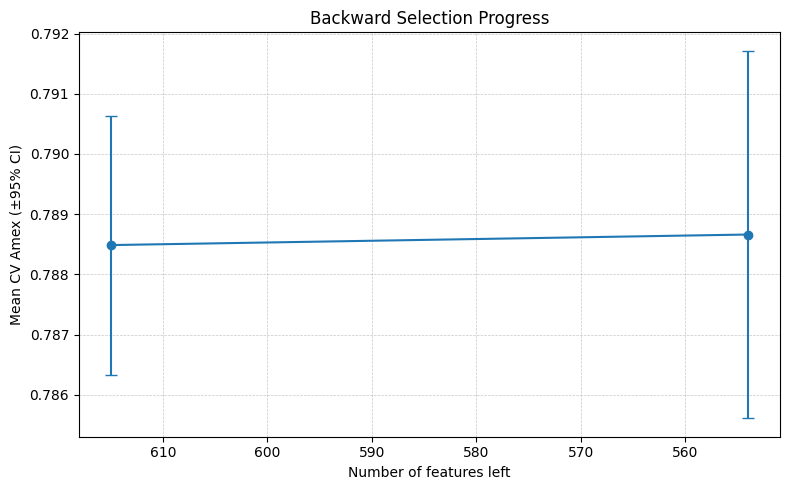

In [52]:
# Prepare data
plot_df = (log_df.sort_values('n_feats_left', ascending=False)
                   .reset_index(drop=True))

x = plot_df['n_feats_left']
y = plot_df['cv_mean']
yerr = [plot_df['cv_mean'] - plot_df['cv_ci_lo'],
        plot_df['cv_ci_hi'] - plot_df['cv_mean']]

# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=4)
plt.gca().invert_xaxis()                 # high → low features left
plt.xlabel("Number of features left")
plt.ylabel("Mean CV Amex (±95% CI)")
plt.title("Backward Selection Progress")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [33]:
test_preds.head(3)

,iter_1,iter_2
customer_ID,,
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,-3.019499,-3.069418
00001bf2e77ff879fab36aa4fac689b9ba411dae63ae397d4263dafa1daedef5,-6.646071,-6.649168
0000210045da4f81e5f122c6bde5c2a617d03eef67f82c5e400fc98e7bd43ce8,-2.922014,-2.885177


In [35]:
log_df

,step,n_feats_left,n_num_left,n_cat_left,max_depth,n_estimators,cv_mean,cv_ci_lo,cv_ci_hi,dropped
0,1,615,545,9,6,350,0.788487,0.786336,0.790637,"[D_86_min, D_79_min, D_145_last, D_92_max, R_1..."
1,2,554,491,8,6,350,0.788662,0.785610,0.791714,"[R_4_max, S_19_last, D_81_min, D_83_min, D_93_..."


In [ ]:
INFERENCE = True

if INFERENCE:
    sub = pd.DataFrame({'customer_ID': test_preds.index,
                        'prediction': test_preds.iter_1.values})
    #sub.to_csv('submission_lgbm_backward_selection_test_preds_615_feats_test_wo_index.csv', index=False)
    display(sub)

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,-3.019499
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,-6.646071
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,-2.922014
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,-0.681319
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,1.977357
...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,-3.900490
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,1.433510
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,0.152213
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,-0.543022


In [ ]:
test_preds.iter_1.values

array([-3.01949949, -6.64607068, -2.92201373, ...,  0.15221332,
       -0.54302249, -2.4237113 ], shape=(924621,))

### LR & WoE & binning